In [4]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
from material_constants import e0
from material_constants import M128YXNiobate as niobate
from apodizations import Apodization

"""
Interdigital Transducer (IDT) = Встречно-Штыревой преобразователь (ВШП)
Pitch - Расстояние между электродами (м)
Np - количество электродов в ВШП
Апертура - Длина электрода. В случае аподизированного ВШП задаётся функцией.

"""

%matplotlib notebook

class IDT:
    """
    Describes IDT with delta-function model.
    """

    def __init__(self, p: float = 10e-6,
                 Np: int = 100,
                 apodization: callable = Apodization.none,
                 aperture: int = 100,
                 material=niobate,
                 freq_sampling: float = 0.1e6,
                 band: str = 'wide',
                 bandwidth: float = 0.05
                 ):
        """

        :param p: Pitch is the distance between electrodes
        :param Np: Quantity of electrodes
        :param apodization: Apodization type (function)
        :param aperture: Aperture (length of a single electrode) length in wavelengths, defines max aperture in apodized filter
        :param material: Material type, required for some constants
        :param freq_sampling: Frequency sampling rate
        :param band: Allows you to configure whether the simulation will be in a wide or in a narrow band
        :param bandwidth: Target bandwidth width as a percentage of main frequency

        """
        self.p = p
        self.Np = Np
        self.material = material
        self.apodization = apodization
        self.a = p / 2

        self.lam = 2 * self.p
        self.f_0 = self.material.v / (2 * self.p)
        self.freq = np.arange(freq_sampling, ((5.5 if band == 'wide' else 1.5) * self.f_0), freq_sampling)
        self.omega = 2 * np.pi * self.freq
        self.Ew_const = 1.694j * self.material.dvv
        self.W = aperture * self.lam

        self.Kw = self.omega / self.material.v  # Вектор волновых чисел
        self.X = np.array([x * self.p for x in range(self.Np)])  # Координаты точечных излучателей

        # Применение аподизации
        self.Pm, self.Wm = self.apodization(self.p, self.Np, self.material.v, self.W, bandwidth)

        # Расчёт множителя элемента (element factor)
        self.Ew = np.array([self.element_factor(k) for k in self.Kw])

        # Расчёт множителя массива элементов (array factor)
        self.A = np.sum(np.array([self.Pm * np.exp(- self.X * self.Kw[i] * 1j) for i in range(len(self.Kw))]),
                        axis=1)

        # Отклик преобразователя (transducer response)
        self.H = - 1j * self.Ew * self.A * np.sqrt(self.omega * self.W * self.material.einf / self.material.dvv)

    def legendre(self, x, v, M: int = 100):
        """
        This function computes the Legendre polynomial P(x)v
        :param x: argument
        :param v: lowercase parameter
        :param M: sampling
        :return: Legendre function value with given parameters
        """

        N = np.ones(M)
        for i in range(1, M):
            m = i
            am = (m - 1 - v) * (m + v) * (1 - x) / 2 / m / m
            N[i] = am * N[i - 1]
        P = np.sum(N)
        return P

    def rho_f(self, beta):
        delta = np.pi * self.a / self.p

        m = np.floor(beta * self.p / (2 * np.pi))
        s = (beta * self.p / (2 * np.pi)) - m

        rho_f = self.material.einf * (2 * np.sin(np.pi * s)) * self.legendre(np.cos(delta), m) / self.legendre(-np.cos(delta), -s)

        return rho_f

    def element_factor(self, beta):
        ew = 1j * self.material.dvv * self.rho_f(beta) / self.material.einf
        return ew


class Filter:

    def __init__(self, idt_1: IDT, idt_2: IDT,
                 d: float = 10e-3, ):
        self.material = idt_1.material
        self.f_0 = idt_1.f_0
        self.freq = idt_1.freq
        self.omega = idt_1.omega

        Cio = 0.01e-12
        YCio = -1j * self.omega * Cio

        # Y21 и Y12 считаем по 2 (принимающему) преобразователю
        self.Y21 = idt_1.H * idt_2.H * np.exp(-1j * idt_2.Kw * d) + YCio
        self.Y12 = self.Y21

        # Y11 и Y22 считаем по 1 (испускающему) преобразователю
        self.Ga = np.abs(idt_1.H ** 2)
        self.Ba = -(scipy.signal.hilbert(self.Ga)).imag
        self.Ct = np.sum(idt_1.Wm * idt_1.material.einf)
        self.Y11 = self.Ga + 1j * self.Ba + 1j * self.omega * self.Ct - YCio
        self.Y22 = self.Y11

    @property
    def s_params(self):
        Z0 = 50
        Y11, Y12, Y21, Y22 = self.Y11, self.Y12, self.Y21, self.Y22

        delta = (1 + Z0 * Y11) * (1 + Z0 * Y22) - Z0 ** 2 * Y12 * Y21
        S11 = ((1 - Z0 * Y11) * (1 + Z0 * Y22) + Z0 ** 2 * Y12 * Y21) / delta
        S12 = (-2 * Z0 * Y12) / delta
        S21 = (-2 * Z0 * Y21) / delta
        S22 = ((1 + Z0 * Y11) * (1 - Z0 * Y22) + Z0 ** 2 * Y12 * Y21) / delta

        return S11, S12, S21, S22


In [5]:
a = IDT(p=10e-6, Np=200, apodization=Apodization.sinc)
b = IDT(p=10e-6, Np=35)


c = Filter(a, b, d=10e-3)

In [10]:
print(a.f_0 * 1e-6)

S = c.s_params

fig, ax = plt.subplots()


ax.plot(a.freq/a.f_0, 20 * np.log10(abs(S[2])))

ax.grid()

198.94999999999996


<IPython.core.display.Javascript object>

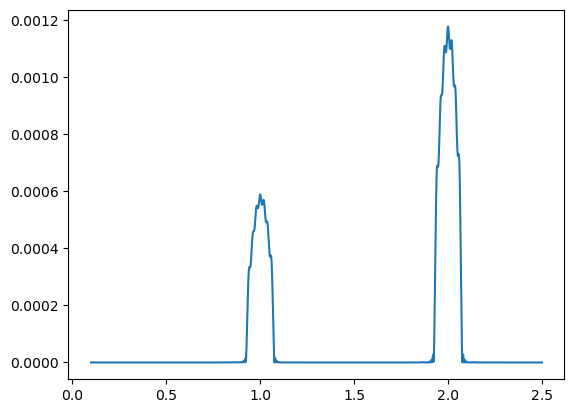

In [9]:
plt.plot(a.freq/a.f_0, np.abs(c.Y21))

<StemContainer object of 3 artists>

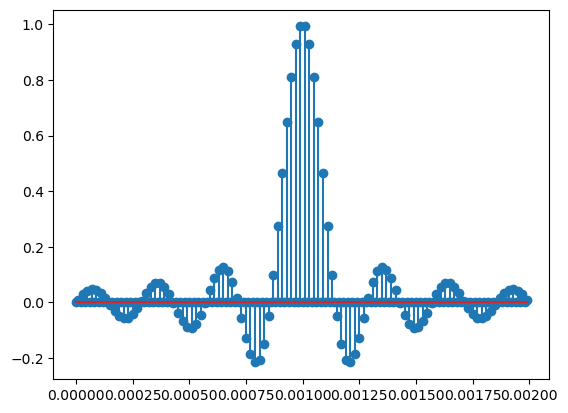

In [10]:
plt.stem(a.ZM, a.Pm)

NameError: name 'H' is not defined

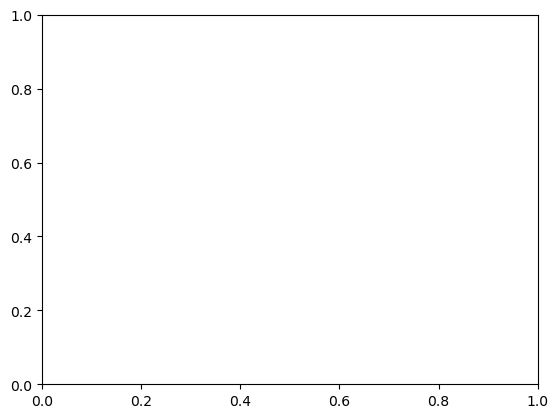

In [11]:

fig, ax = plt.subplots()

fourier = np.fft.fft(H**2,
                       )
ax.plot(np.fft.fftshift(fourier))
#ax.set_xlim(1000, 2000)

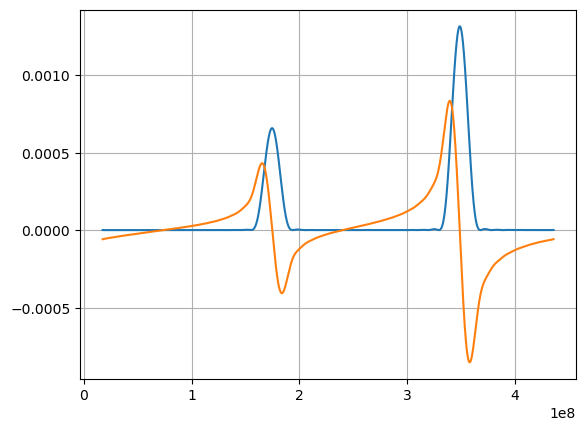

In [12]:
import scipy

Ga = np.abs(b.H**2)

Ba = -(scipy.signal.hilbert(Ga)).imag

fig, axs = plt.subplots()
axs.plot(b.freq, Ga, b.freq, Ba)
axs.grid()

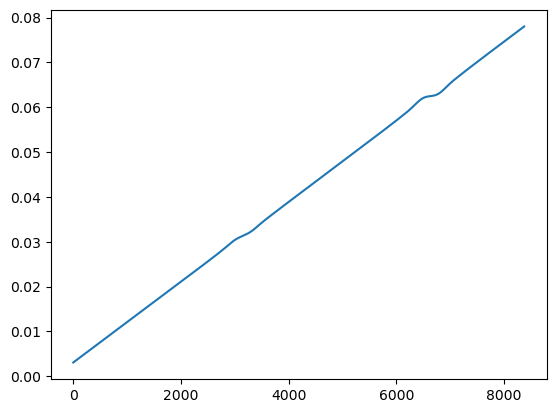

In [13]:
plt.plot(c.Y11.imag)